<a href="https://colab.research.google.com/github/recozers/LIME/blob/main/Explainable_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining a single instance of ResNet34

ResNet34 is an image classification package. It is a black box model, and thus we do not know specifically how it gets from an image to a label. We're unsure if is looking at the actual item we try to classify, or using context clues to guess. For example does it know the image below is a giraffe, or is it using the surrounding environment to guess that a giraffe is in this photo? (PS i took this photo)


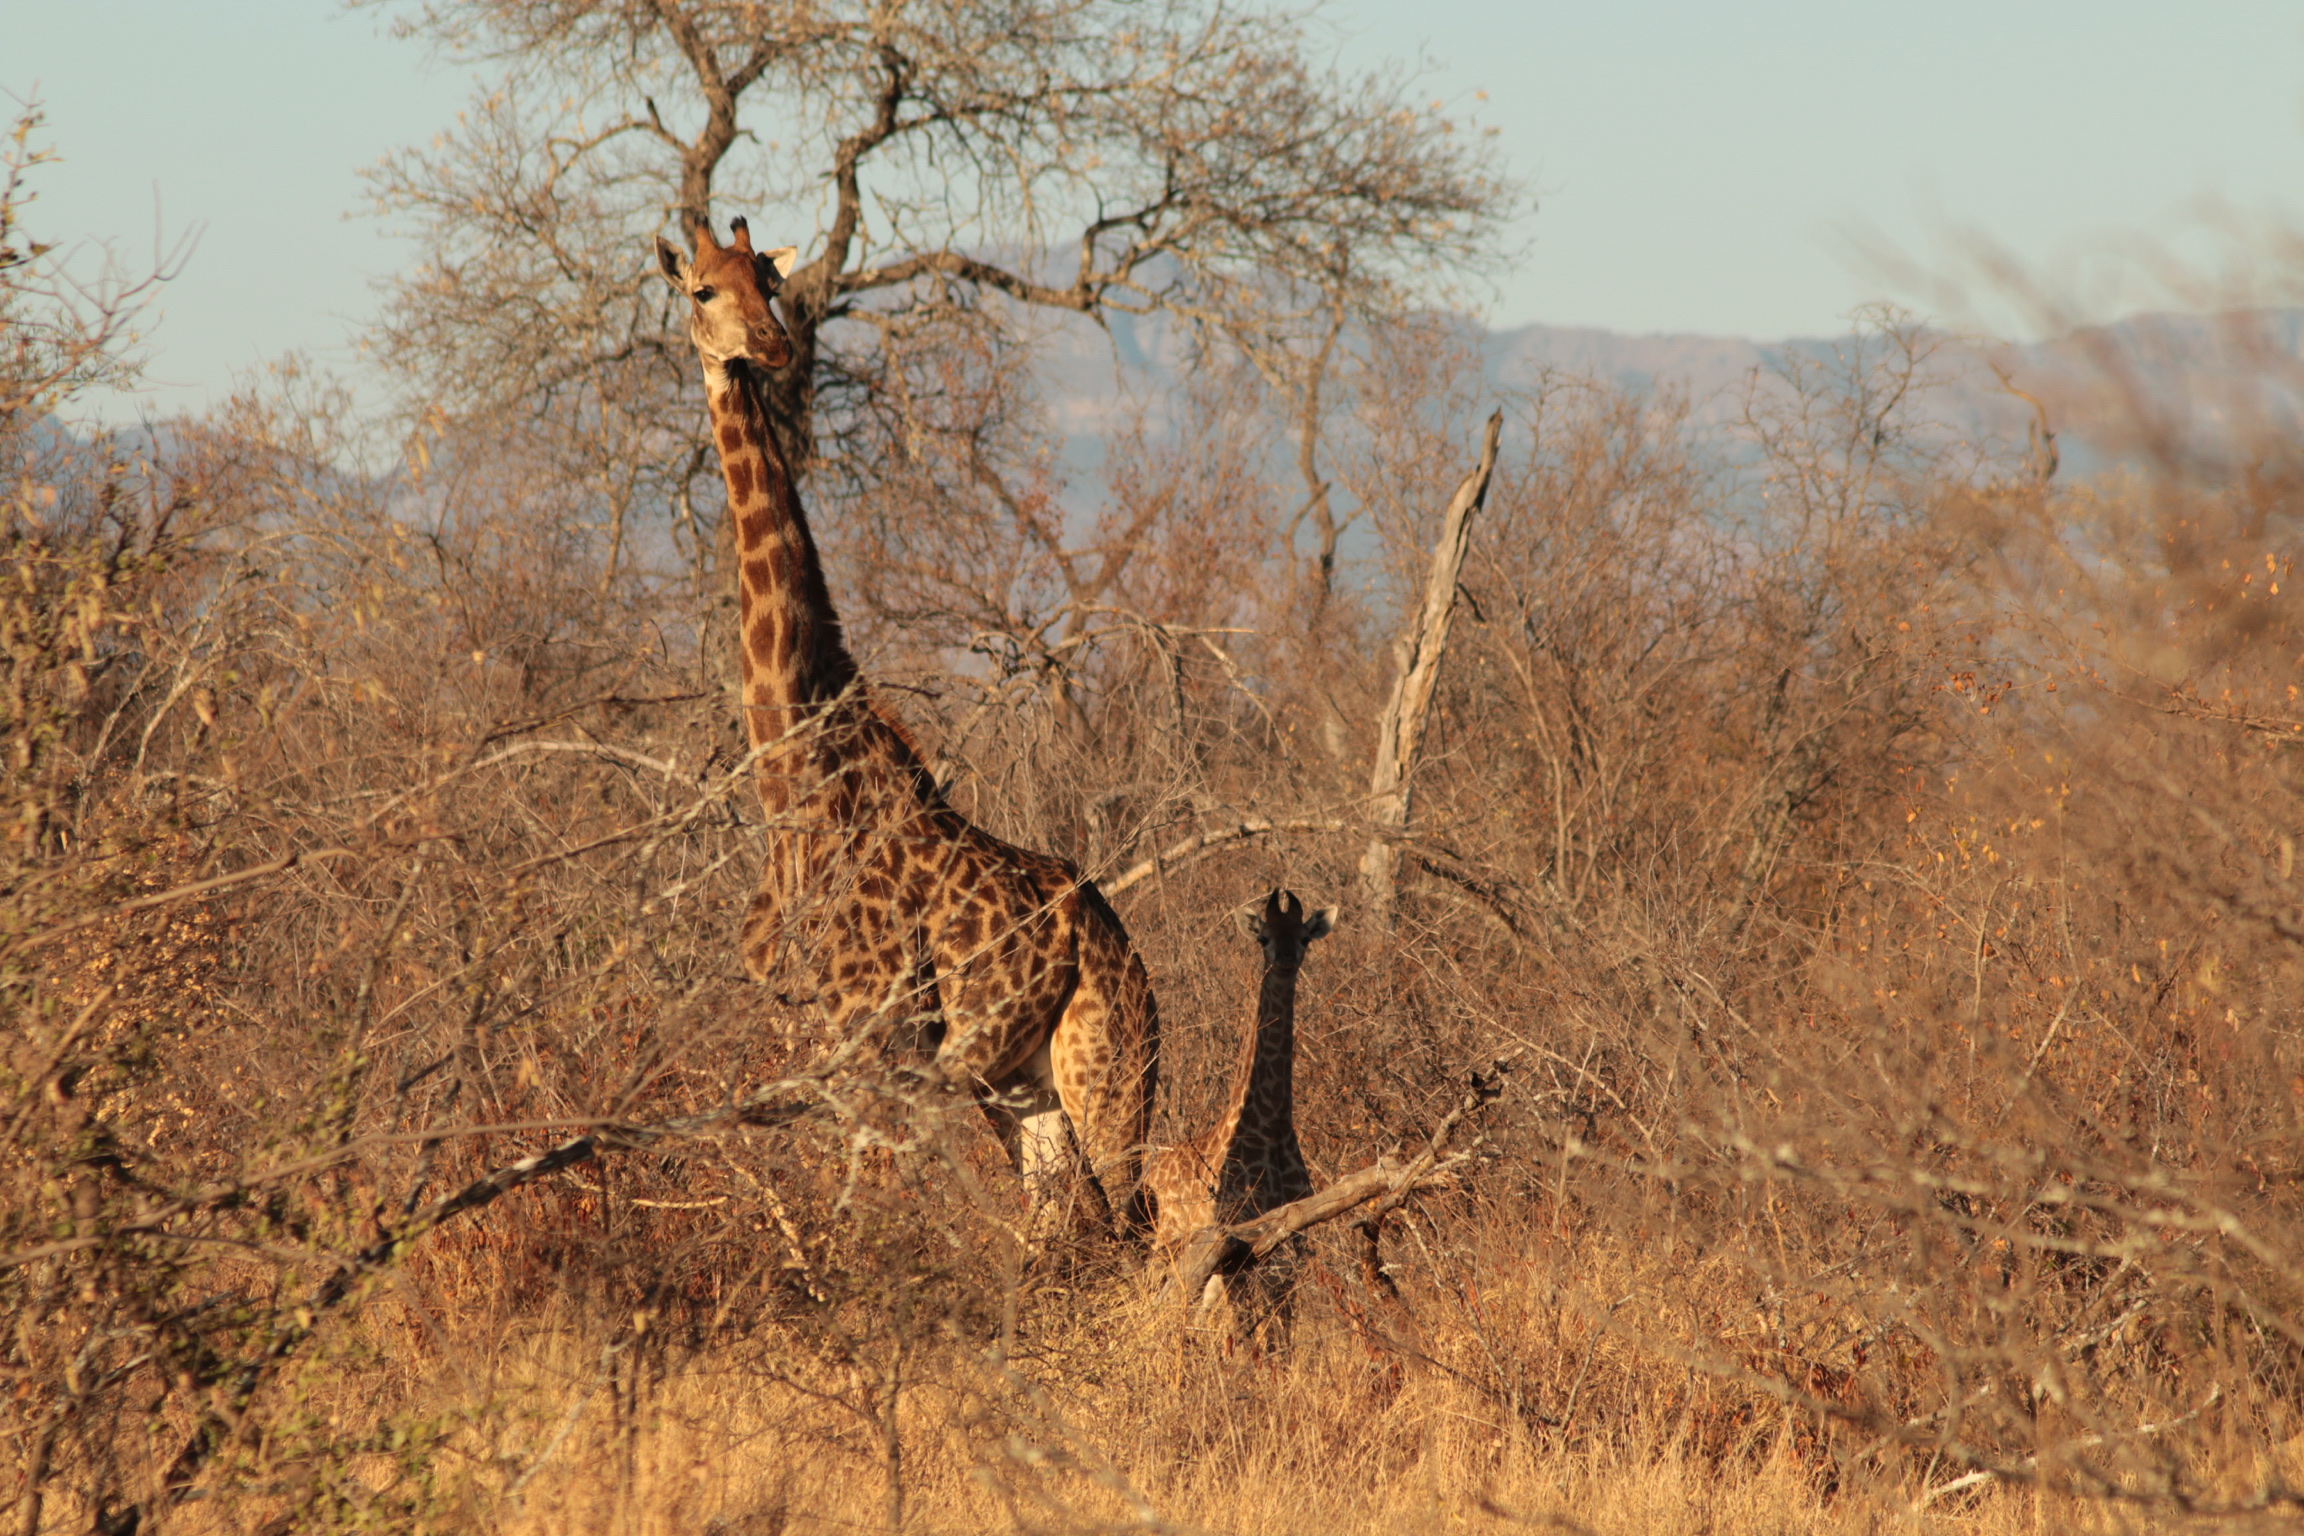

Lets start by feeding the image to the model to make sure it does recognise the Giraffe. For this we will need to import and load the model, as well as some packages. Then we will need to turn the image into something the model can understand.

In [1]:
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plot
from torchvision import transforms
from PIL import Image
import urllib
import json

Load the imagenet labels so we can actually understand the predictions.

In [27]:
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = json.loads(urllib.request.urlopen(url).read())

In [22]:
resnet34 = models.resnet34(pretrained = True)
resnet34.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = Image.open("IMG_9446.jpg").convert("RGB")

input_tensor = preprocess(img).unsqueeze(0)

output = resnet34(input_tensor)

_, predicted_class = torch.max(output, 1)

predicted_index = predicted_class.item()
pred_lab = imagenet_labels[predicted_index]
print(f"Predicted class:", pred_lab)


Predicted class: cheetah


In [25]:
if any("giraffe" in label.lower() for label in imagenet_labels):
    print("Giraffe is in the ImageNet labels!")
else:
    print("Giraffe is not in the ImageNet labels.")

Giraffe is not in the ImageNet labels.


Interestingly the model has predicted Cheetah, this might suggest it's looking at context, as they share a habitat (the african bush). The code above suggests that giraffe isn't in the imagenet labels. I have to say i didn't believe it but upon manual inspection that does seem to be true. I think this makes it even more interesting to look at the explanation, givent he model has never seen a giraffe, how does it go about deciding what it is? Now what explainable technique should we use? LIME, SHAP, Anchor? I'm going to use LIME to look at the 'superpixels' but Anchor would also be appropriate.  

## Why LIME?

Given its flexibility, I think it's a good choice for image classification given there are so many different ones. If i wanted to use a different version of resnet or something else entirely it would be trivial to adjust the code. I also didn't have a large computational limit so the drawback of it being computationally intensive was minimal. The theory of it focusing on background information also informed my choice as it is pertubing the image randomly rather than trying to identify important parts and zoning in on those like Anchor does.

One possible improvement would be to run more num_examples. It would take a while to run but it could improve the stability of the predictions which is something i have observed be slightly difficult.

We need to install and load a few new packages to load LIME and be able to demonstrate its output on the image itself.

In [ ]:
!pip install lime

In [5]:
from lime import lime_image
from skimage.segmentation import mark_boundaries


Now lets set up LIME's image explainer. We will need to convert the image to a numpy array for this to work. This will take a while as we are creating many different pertubed samples of the image and feeding it to the model. We will then visualise the superpixels (parts of the image that contribute to the predctions the most).

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/100 [00:00<?, ?it/s]

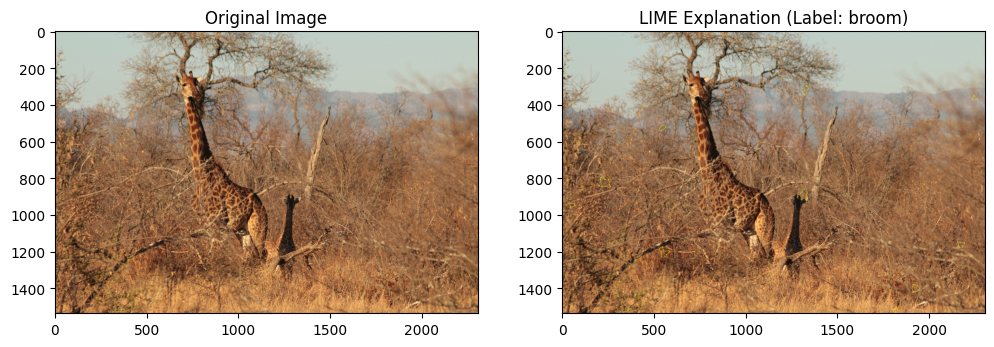

In [29]:
explainer = lime_image.LimeImageExplainer()
resnet34 = models.resnet34(pretrained=True).to(torch.device("cuda"))

def predict(images):
    batch = torch.stack([preprocess(Image.fromarray(np.uint8(img))) for img in images]).to(torch.device("cuda"))
    with torch.no_grad():
        outputs = resnet34(batch)
    return outputs.cpu().numpy()

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

img = np.array(Image.open("IMG_9446.jpg"))

# Run LIME explanation
explanation = explainer.explain_instance(img, predict, top_labels=1, hide_color=0, num_samples=100)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,  # Show only the parts of the image that contribute positively to the class
    num_features=10,  # Number of superpixels to highlight
    hide_rest=False  # Show the entire image, not just the important regions
)

# Display the image with superpixel boundaries
fig, ax = plot.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title("Original Image")

# Visualize the superpixels using mark_boundaries
ax[1].imshow(mark_boundaries(temp / 255.0, mask))
ax[1].set_title(f"LIME Explanation (Label: {imagenet_labels[explanation.top_labels[0]]})")

plot.show()


As we can see here the top explanation is now a plunger (or a broomstick depending on your output). This shows that the prediction is not robust at all, the super pixels are distributed randomly across the image. So the model seems to be using context clues and pretty much guessing. Perhaps its unfair to feed it an image of an animal thats spent millions of years developing camoflauge to be difficult to see.

Just for fun, here's an image of an actual cheetah I took being identified correctly by Resnet34.

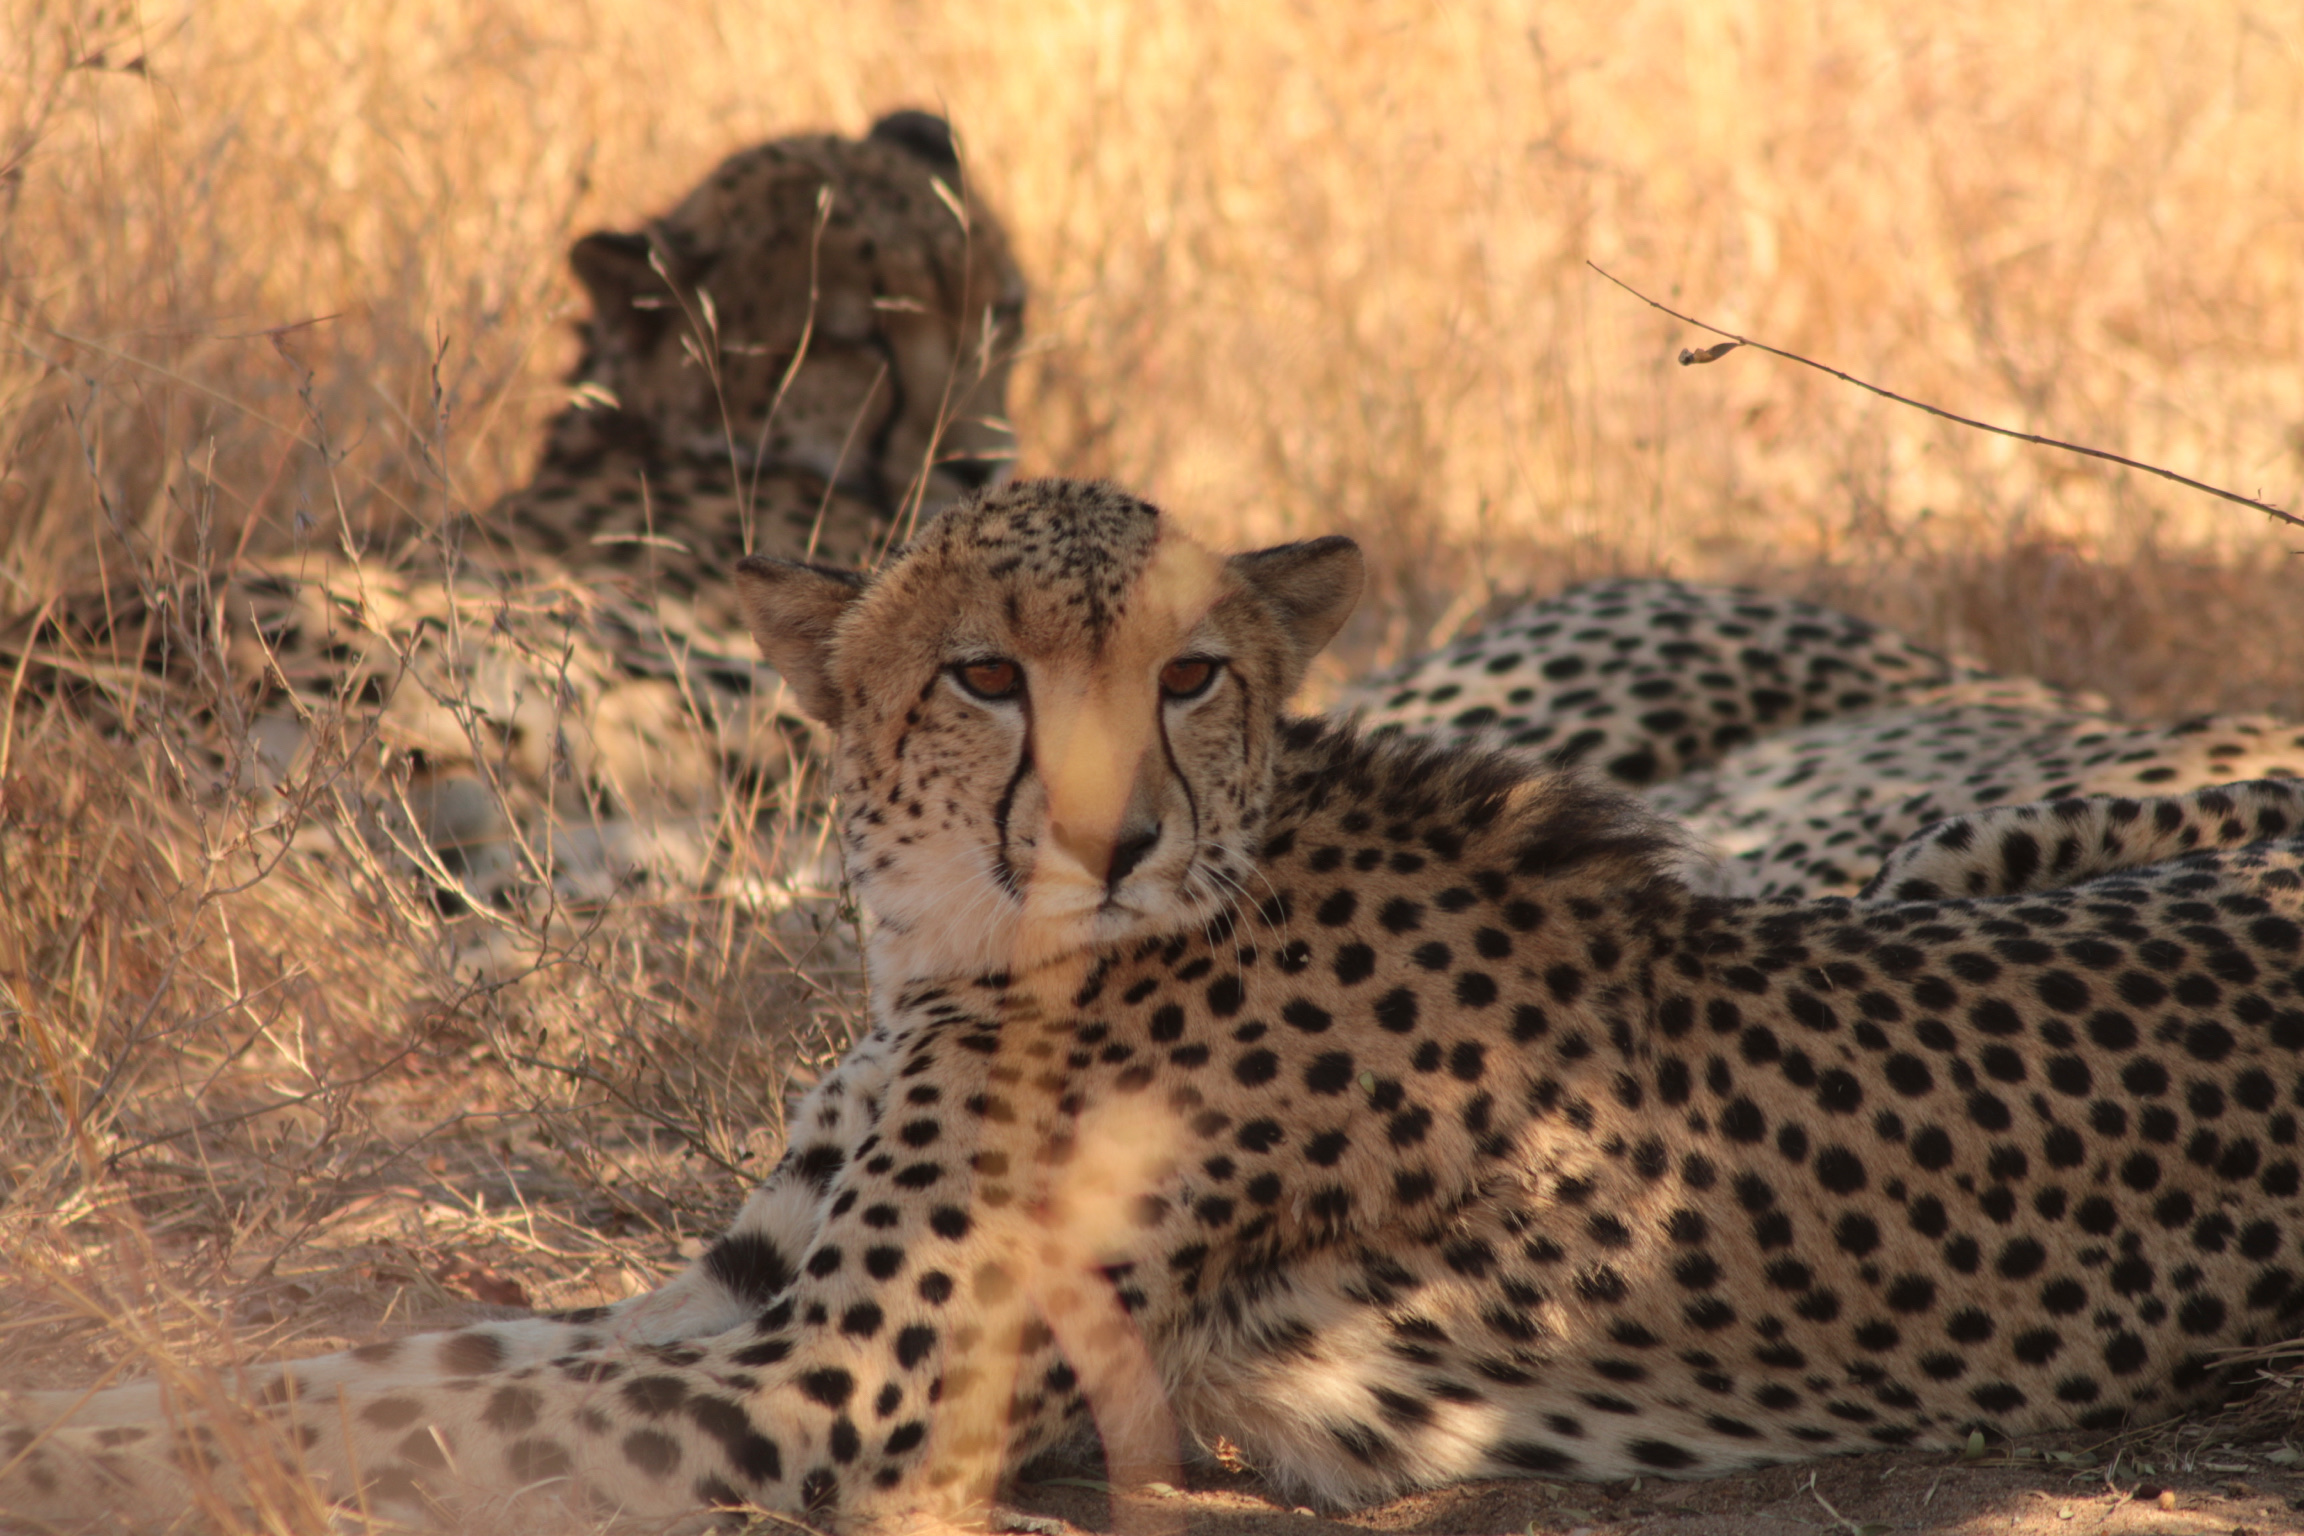

In [21]:
resnet34 = models.resnet34(pretrained = True)
resnet34.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = Image.open("IMG_9553.jpg").convert("RGB")

input_tensor = preprocess(img).unsqueeze(0)

output = resnet34(input_tensor)

_, predicted_class = torch.max(output, 1)

predicted_index = predicted_class.item()
pred_lab = imagenet_labels[predicted_index]
print(f"Predicted class:", pred_lab)


Predicted class: cheetah
